In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from functools import partial
from collections import OrderedDict, defaultdict
import qiskit as qk
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import state_fidelity, Statevector, DensityMatrix, partial_trace
from qiskit.tools.visualization import circuit_drawer, plot_histogram

In [2]:
def vector_from_counts(counts):
    return np.sqrt(np.array(list(counts)) / np.sum(list(counts)))

def completeCounts(counts):
    qubits = int((len(list(counts.keys())[0]) + 1)/2)
    ret = OrderedDict()
    for i in range(2**qubits):
        s = "{0:b}".format(i)
        ret[''.join(['0' for j in range(qubits - len(s))]) + s] = 0
    for key, value in counts.items():
        k = key.replace(' ', '')
        ret[k] = value
    return ret

In [3]:
#qk.IBMQ.save_account('AUTHORIZATION TOKEN GOES HERE') #EXECUTE ONLY ONCE: The access token is stored in temp files inside 
ibmq_provider = qk.IBMQ.load_account()

C:\Users\jeany\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


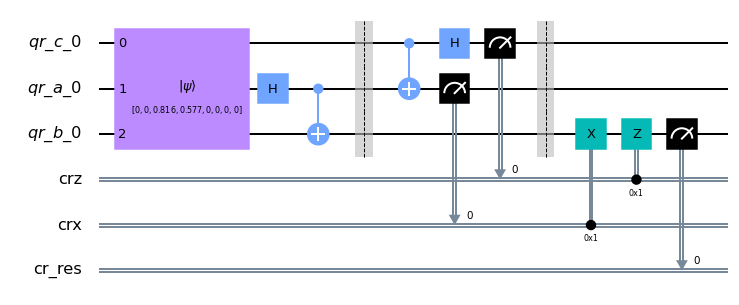

In [4]:
qrc, qra, qrb = qk.QuantumRegister(1, name='qr_c'), qk.QuantumRegister(1, name='qr_a'), qk.QuantumRegister(1, name='qr_b')
crz, crx = qk.ClassicalRegister(1, name='crz'), qk.ClassicalRegister(1, name='crx')
cr_res = qk.ClassicalRegister(1, name='cr_res')
qc = qk.QuantumCircuit(qrc, qra, qrb, crz, crx, cr_res)

p_0 = 2/3

init_vector = [0, 0, np.sqrt(p_0), np.sqrt(1 - p_0), 0, 0, 0, 0] #Initialize to \alpha |010> + \beta |011>
qc.initialize(init_vector, [qrc, qra, qrb]) #Initialize system state with init_vector
qc.h(1)
qc.cx(1,2)

qc.barrier()

qc.cx(0,1)
qc.h(0)

qc.measure(qrc, crz)
qc.measure(qra, crx)

qc.barrier()

qc.x(qrb).c_if(crx, 1)
qc.z(qrb).c_if(crz, 1)

qc.measure(qrb, cr_res)

qc.draw('mpl')

## Simulated output (local):

{'0 0 0': 1333, '0 0 1': 1371, '0 1 0': 1420, '0 1 1': 1341, '1 0 0': 692, '1 0 1': 645, '1 1 0': 697, '1 1 1': 693}
DensityMatrix([[0.66711426+0.j, 0.47115119+0.j],
               [0.47115119+0.j, 0.33288574+0.j]],
              dims=(2,))


Text(0.5, 0, 'B')

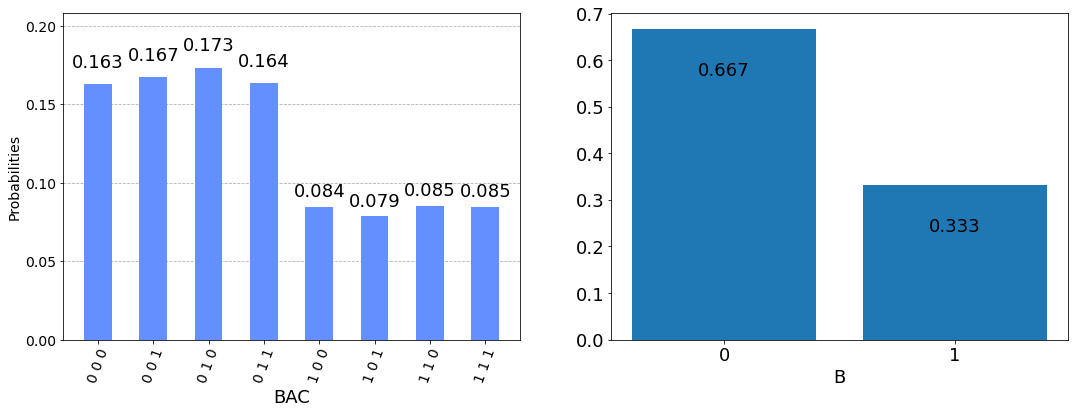

In [5]:
job = qk.execute(qc, backend=qk.Aer.get_backend('qasm_simulator'), shots=8192)
res = job.result()

counts = res.get_counts(qc)
print(counts)

final_state = Statevector(vector_from_counts(counts.values()))
final_state_matrix = DensityMatrix(final_state)
rho_b = partial_trace(final_state_matrix, [0,1])
print(rho_b)

fig = plt.figure(figsize=(18,6))
plt.rcParams.update({'font.size': 18})
ax1 = fig.add_subplot(121)
plot_histogram(counts, ax=ax1)
ax1.set_xlabel('BAC')

ax2 = fig.add_subplot(122)
indexes = ['0', '1']
values = [np.abs(rho_b.data[0][0]), np.abs(rho_b.data[1][1])]
ax2.bar(indexes, values)
for i, v in enumerate(values):
    ax2.text(i, v - .1, str(round(v,3)), color='black', ha='center')
ax2.set_xlabel('B')

## Real QC execution:

Current real QCs can't continue to operate after a measurement is done on any of its qubits. Because of this, the classical-conditional gates (those in section 3 of the circuit) cannot be executed outside of the simulator. A possible workaround is to replace the classical-conditionals with 'cx' and 'cz' gates, but those defeat the spirit of quantum teleportation, as all the operations are then done locally.

Another workaround would be to design a similar circuit replacing the conditionals with deterministic gates. Thus, after executing the original quantum teleportation circuit up to stage 2 (and recording the outcomes of the measurements done on C and A), the "new" circuit would be run, selecting the 'x' and 'z' operations on qubit B based on the outcome of the previous execution. It's even possible to simplify this second run, eliminating the Hadamard gate on C, as it doesn't contribute to the final reduced density matrix $\rho_B$. However, the IBMQ interface doesn't allow for a classical parameter to be varied on each shot, so we can't do it this way in practice, or we would have to send thousands of jobs to the server, each with a different fixed value for the conditionals (and I'm not willing to get flagged by IBM...).

We will attempt the first method in the following section.

### All Local operations (Quantum 'local-portation'):

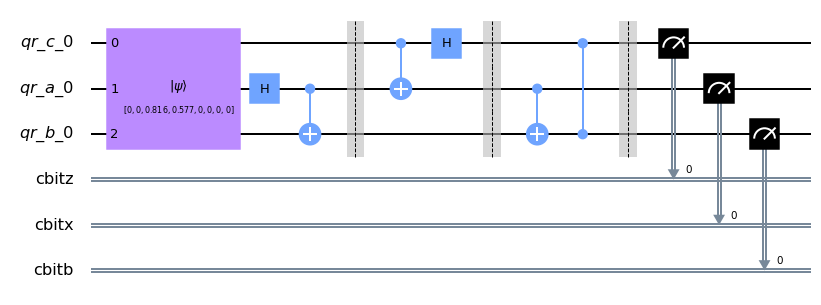

In [6]:
qrc, qra, qrb = qk.QuantumRegister(1, name='qr_c'), qk.QuantumRegister(1, name='qr_a'), qk.QuantumRegister(1, name='qr_b')
crz, crx = qk.ClassicalRegister(1, name='cbitz'), qk.ClassicalRegister(1, name='cbitx')
cr_res = qk.ClassicalRegister(1, name='cbitb')
qc = qk.QuantumCircuit(qrc, qra, qrb, crz, crx, cr_res)

p_0 = 2/3

init_vector = [0, 0, np.sqrt(p_0), np.sqrt(1 - p_0), 0, 0, 0, 0] #Initialize to \alpha |010> + \beta |011>
qc.initialize(init_vector, [qrc, qra, qrb]) #Initialize system state with init_vector
qc.h(1)
qc.cx(1,2)

qc.barrier()

qc.cx(0,1)
qc.h(0)

qc.barrier()

qc.cx(qra, qrb) #Local operation
qc.cz(qrc, qrb) #Local operation

qc.barrier()

qc.measure(qrc, crz)
qc.measure(qra, crx)
qc.measure(qrb, cr_res)

qc.draw('mpl')

ibmq_ourense
{'0 0 0': 2136, '0 0 1': 1748, '0 1 0': 1045, '0 1 1': 453, '1 0 0': 979, '1 0 1': 691, '1 1 0': 507, '1 1 1': 633}
DensityMatrix([[0.65698242+0.j, 0.46490268+0.j],
               [0.46490268+0.j, 0.34301758+0.j]],
              dims=(2,))


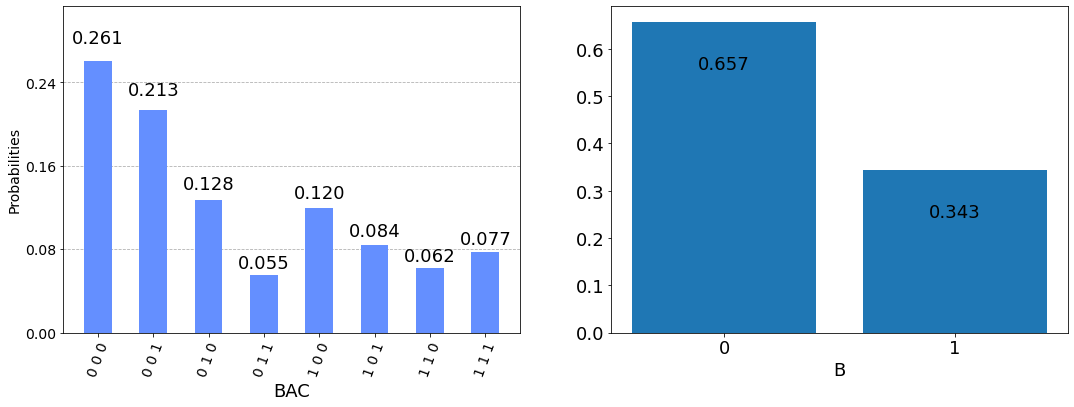

In [10]:
ibmq_backend = least_busy(ibmq_provider.backends(filters=lambda b: b.configuration().n_qubits>=3 and not b.configuration().simulator and b.status().operational==True))
print(ibmq_backend)

job = qk.execute(qc, backend=ibmq_backend, shots=8192)
res = job.result()

counts = res.get_counts(qc)
print(counts)

final_state = Statevector(vector_from_counts(counts.values()))
final_state_matrix = DensityMatrix(final_state)
rho_b = partial_trace(final_state_matrix, [0,1])
print(rho_b)

fig = plt.figure(figsize=(18,6))
plt.rcParams.update({'font.size': 18})
ax1 = fig.add_subplot(121)
plot_histogram(counts, ax=ax1)
ax1.set_xlabel('BAC')

ax2 = fig.add_subplot(122)
indexes = ['0', '1']
values = [np.abs(rho_b.data[0][0]), np.abs(rho_b.data[1][1])]
ax2.bar(indexes, values)
for i, v in enumerate(values):
    ax2.text(i, v - .1, str(round(v,3)), color='black', ha='center')
ax2.set_xlabel('B');

Qiskit compiles all circuits to only CNOT, U2 and U3 (2 and 3 param general rotations) gates. The above circuit is compiled into the following:

![title](circuit_diagrams/circuit-kfkfg6zk.svg)

This is the actual compiled OPENQASM code the machine executes:
~~~
OPENQASM 2.0;
include "qelib1.inc";

qreg q[15];

creg cbitz[1];
creg cbitx[1];
creg cbitc[1];


u2(0, 0) q[0];
cx q[1], q[0];
u2(0, 0) q[0];
cx q[1], q[0];
u3(0.3077398543351937, 0, 0) q[14];
cx q[0], q[14];
u3(-0.3077398543351937, 0, 0) q[14];
cx q[14], q[13];
cx q[13], q[14];
cx q[14], q[13];
cx q[13], q[1];
cx q[1], q[13];
u3(-0.3077398543351937, 0, 0) q[1];
cx q[0], q[1];
u2(0, 3.141592653589793) q[0];
u3(0.3077398543351937, 0, 0) q[1];
cx q[13], q[1];
cx q[0], q[1];
cx q[1], q[0];
cx q[0], q[1];
cx q[1], q[13];
barrier q[0], q[1], q[13];
cx q[0], q[1];
u2(0, 3.141592653589793) q[0];
barrier q[0], q[1], q[13];
cx q[0], q[14];
cx q[1], q[13];
u2(0, 3.141592653589793) q[13];
cx q[14], q[0];
cx q[0], q[14];
cx q[14], q[13];
u2(0, 3.141592653589793) q[13];
barrier q[0], q[3], q[10], q[1], q[6], q[9], q[12], q[2], q[8], q[5], q[11], q[13], q[14], q[4], q[7];
measure q[14] -> cbitz[0];
measure q[1] -> cbitx[0];
measure q[13] -> cbitc[0];
~~~

## Double qubit teleportation:

We will now setup a circuit to teleport an entangled qubit (Ex. III.2.b). We will use again only local operations, because of the hardware limitations.
The initial state will be given by
$$ |\psi_{DC}> = \sqrt{p_e} \ |0> (\sqrt{p_0} \ |0> + \sqrt{1 - p_0} \ |1>) + \sqrt{1 - p_e} \ |1> (\sqrt{p_1} \ |0> + \sqrt{1 - p_1} \ |1>), $$
$$ |\psi_{AB}> = |1> \otimes \ |0>$$

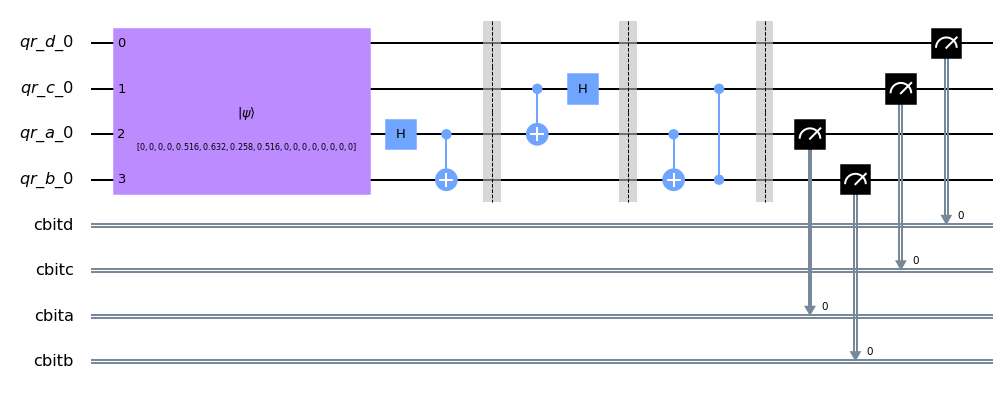

In [11]:
qrd, qrc = qk.QuantumRegister(1, name='qr_d'), qk.QuantumRegister(1, name='qr_c')
qra, qrb = qk.QuantumRegister(1, name='qr_a'), qk.QuantumRegister(1, name='qr_b')
cr_d, cr_c = qk.ClassicalRegister(1, name='cbitd'), qk.ClassicalRegister(1, name='cbitc')
cr_a, cr_b = qk.ClassicalRegister(1, name='cbita'), qk.ClassicalRegister(1, name='cbitb')
qc = qk.QuantumCircuit(qrd, qrc, qra, qrb, cr_d, cr_c, cr_a, cr_b)

p_e = 1/3
p_0 = 4/5
p_1 = 6/10

init_vector = [0, 0, 0, 0, \
               np.sqrt(p_e) * np.sqrt(p_0), np.sqrt(1 - p_e) * np.sqrt(p_1), np.sqrt(p_e) * np.sqrt(1 - p_0), np.sqrt(1 - p_e) * np.sqrt(1 - p_1), \
               0, 0, 0, 0, \
               0, 0, 0, 0]
qc.initialize(init_vector, [qrd, qrc, qra, qrb]) #Initialize system state with init_vector
qc.h(2)
qc.cx(2,3)

qc.barrier()

qc.cx(1,2)
qc.h(1)

qc.barrier()

qc.cx(2, 3) #Local operation
qc.cz(1, 3) #Local operation

qc.barrier()

qc.measure(qra, cr_a)
qc.measure(qrb, cr_b)
qc.measure(qrc, cr_c)
qc.measure(qrd, cr_d)

qc.draw('mpl')

## Simulated output (local):

{'0 0 0 0': 536, '0 0 0 1': 827, '0 0 1 0': 534, '0 0 1 1': 800, '0 1 0 0': 557, '0 1 0 1': 822, '0 1 1 0': 549, '0 1 1 1': 823, '1 0 0 0': 139, '1 0 0 1': 572, '1 0 1 0': 137, '1 0 1 1': 551, '1 1 0 0': 138, '1 1 0 1': 527, '1 1 1 0': 129, '1 1 1 1': 551} 

DensityMatrix([[0.265625  +0.j, 0.3257107 +0.j, 0.13266613+0.j,
                0.26708159+0.j],
               [0.3257107 +0.j, 0.39941406+0.j, 0.16268817+0.j,
                0.32754986+0.j],
               [0.13266613+0.j, 0.16268817+0.j, 0.06628418+0.j,
                0.13342342+0.j],
               [0.26708159+0.j, 0.32754986+0.j, 0.13342342+0.j,
                0.26867676+0.j]],
              dims=(2, 2)) 

Original values:
p_e = 0.3333333333333333
p_0 = 0.8
p_1 = 0.6
Teleported values:
p_e = 0.3319091796875
p_0 = 0.8002942258183156
p_1 = 0.5978439612643888


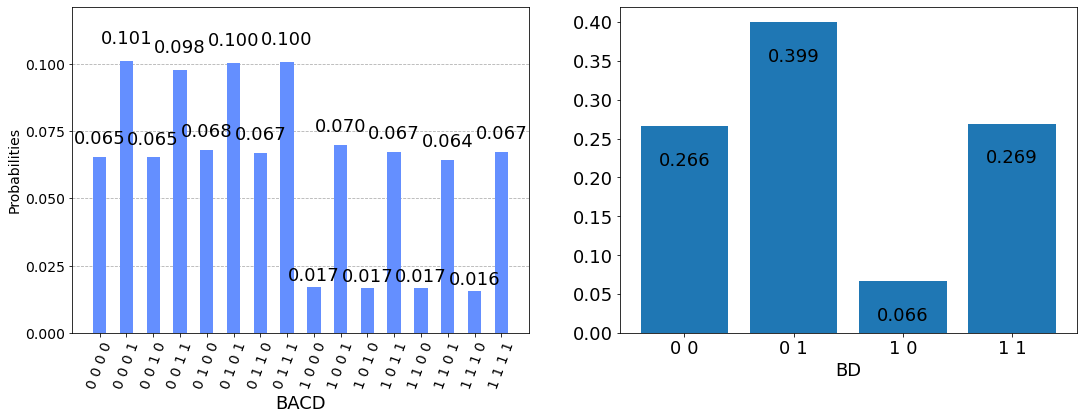

In [12]:
job = qk.execute(qc, backend=qk.Aer.get_backend('qasm_simulator'), shots=8192)
res = job.result()

counts = res.get_counts(qc)
print(counts, '\n')

final_state = Statevector(vector_from_counts(completeCounts(counts).values()))
final_state_matrix = DensityMatrix(final_state)
rho_db = partial_trace(final_state_matrix, [1, 2])
print(rho_db, '\n')

fig = plt.figure(figsize=(18,6))
plt.rcParams.update({'font.size': 18})
ax1 = fig.add_subplot(121)
plot_histogram(counts, ax=ax1)
ax1.set_xlabel('BACD')

ax2 = fig.add_subplot(122)
indexes = ['0 0', '0 1', '1 0', '1 1']
values = [np.abs(rho_db.data[0][0]), np.abs(rho_db.data[1][1]), np.abs(rho_db.data[2][2]), np.abs(rho_db.data[3][3])]
ax2.bar(indexes, values)
for i, v in enumerate(values):
    if v != 0:
        ax2.text(i, v - .05, str(round(v,3)), color='black', ha='center')
ax2.set_xlabel('BD')

#The teleported probabilities are:
t_p_0 = values[0] / (values[0] + values[2])
t_p_1 = values[1] / (values[1] + values[3])
t_p_e = ((values[0] / t_p_0) + (1 - values[1] / t_p_1) + (values[2] / (1 - t_p_0)) + (1 - values[3] / (1 - t_p_1))) / 4
print('Original values:')
print('p_e =', p_e)
print('p_0 =', p_0)
print('p_1 =', p_1)
print('Teleported values:')
print('p_e =', t_p_e)
print('p_0 =', t_p_0)
print('p_1 =', t_p_1)

## Real QC execution:

ibmq_16_melbourne
{'0 0 0 0': 809, '0 0 0 1': 609, '0 0 1 0': 691, '0 0 1 1': 520, '0 1 0 0': 536, '0 1 0 1': 370, '0 1 1 0': 542, '0 1 1 1': 377, '1 0 0 0': 632, '1 0 0 1': 444, '1 0 1 0': 527, '1 0 1 1': 359, '1 1 0 0': 571, '1 1 0 1': 373, '1 1 1 0': 476, '1 1 1 1': 356} 

DensityMatrix([[0.31469727+0.j, 0.26839721+0.j, 0.2904847 +0.j,
                0.24216199+0.j],
               [0.26839721+0.j, 0.22900391+0.j, 0.24745369+0.j,
                0.20628754+0.j],
               [0.2904847 +0.j, 0.24745369+0.j, 0.26928711+0.j,
                0.22434556+0.j],
               [0.24216199+0.j, 0.20628754+0.j, 0.22434556+0.j,
                0.18701172+0.j]],
              dims=(2, 2)) 

Original values:
p_e = 0.3333333333333333
p_0 = 0.8
p_1 = 0.6
Teleported values:
p_e = 0.583984375
p_0 = 0.5388795986622074
p_1 = 0.5504694835680751


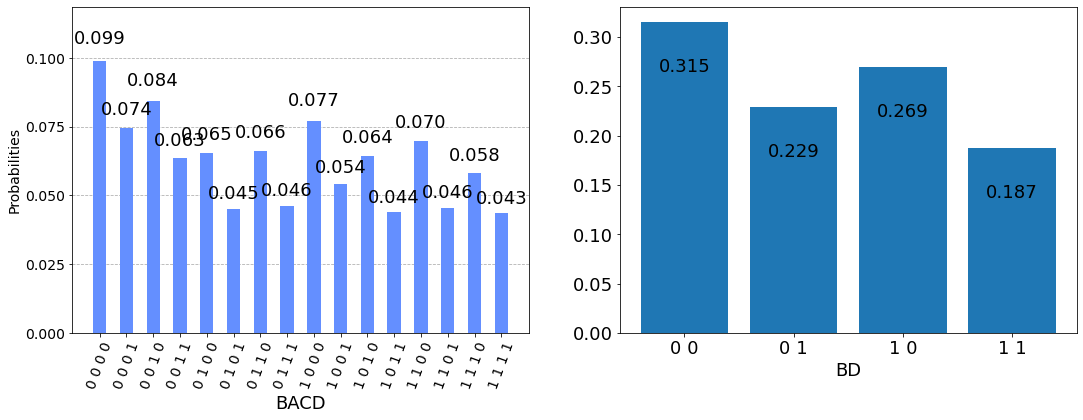

In [16]:
ibmq_backend = least_busy(ibmq_provider.backends(filters=lambda b: b.configuration().n_qubits>=4 and not b.configuration().simulator and b.status().operational==True))
print(ibmq_backend)

job = qk.execute(qc, backend=ibmq_backend, shots=8192)
res = job.result()

counts = res.get_counts(qc)
print(counts, '\n')

final_state = Statevector(vector_from_counts(completeCounts(counts).values()))
final_state_matrix = DensityMatrix(final_state)
rho_db = partial_trace(final_state_matrix, [1, 2])
print(rho_db, '\n')

fig = plt.figure(figsize=(18,6))
plt.rcParams.update({'font.size': 18})
ax1 = fig.add_subplot(121)
plot_histogram(counts, ax=ax1)
ax1.set_xlabel('BACD')

ax2 = fig.add_subplot(122)
indexes = ['0 0', '0 1', '1 0', '1 1']
values = [np.abs(rho_db.data[0][0]), np.abs(rho_db.data[1][1]), np.abs(rho_db.data[2][2]), np.abs(rho_db.data[3][3])]
ax2.bar(indexes, values)
for i, v in enumerate(values):
    if v != 0:
        ax2.text(i, v - .05, str(round(v,3)), color='black', ha='center')
ax2.set_xlabel('BD')

#The teleported probabilities are:
t_p_0 = values[0] / (values[0] + values[2])
t_p_1 = values[1] / (values[1] + values[3])
t_p_e = ((values[0] / t_p_0) + (1 - values[1] / t_p_1) + (values[2] / (1 - t_p_0)) + (1 - values[3] / (1 - t_p_1))) / 4
print('Original values:')
print('p_e =', p_e)
print('p_0 =', p_0)
print('p_1 =', p_1)
print('Teleported values:')
print('p_e =', t_p_e)
print('p_0 =', t_p_0)
print('p_1 =', t_p_1)

## Real QC execution (ibmq_santiago, 5 qubits, QV=32):

ibmq_santiago
{'0 0 0 0': 330, '0 0 0 1': 240, '0 0 1 0': 363, '0 0 1 1': 206, '0 1 0 0': 350, '0 1 0 1': 244, '0 1 1 0': 352, '0 1 1 1': 209, '1 0 0 0': 859, '1 0 0 1': 419, '1 0 1 0': 898, '1 0 1 1': 486, '1 1 0 0': 1147, '1 1 0 1': 471, '1 1 1 0': 1112, '1 1 1 1': 506} 

DensityMatrix([[0.17028809+0.j, 0.13651704+0.j, 0.28840332+0.j,
                0.19774397+0.j],
               [0.13651704+0.j, 0.10974121+0.j, 0.2313554 +0.j,
                0.15841381+0.j],
               [0.28840332+0.j, 0.2313554 +0.j, 0.49023438+0.j,
                0.3351665 +0.j],
               [0.19774397+0.j, 0.15841381+0.j, 0.3351665 +0.j,
                0.22973633+0.j]],
              dims=(2, 2)) 

Original values:
p_e = 0.3333333333333333
p_0 = 0.8
p_1 = 0.6
Teleported values:
p_e = 0.6605224609375
p_0 = 0.2578081685455553
p_1 = 0.3232650125854009


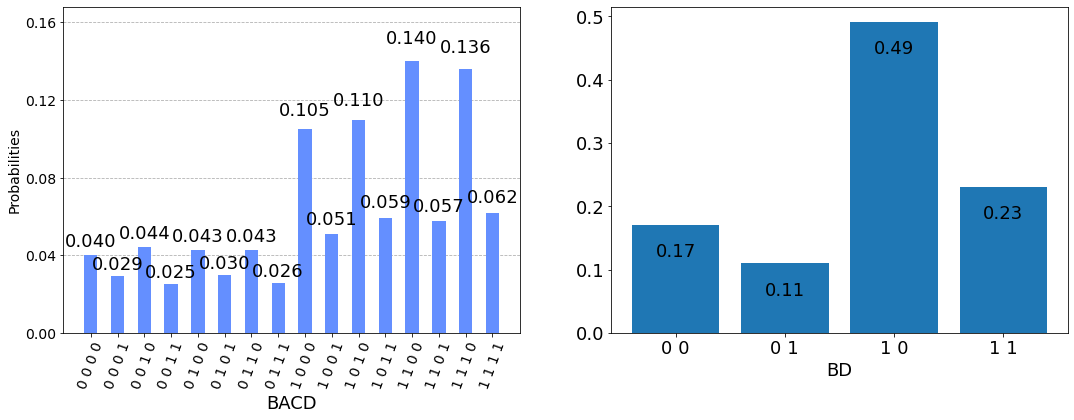

In [17]:
#ibmq_backend = least_busy(ibmq_provider.backends(filters=lambda b: b.configuration().n_qubits>=4 and not b.configuration().simulator and b.status().operational==True))
ibmq_backend = ibmq_provider.backends('ibmq_santiago')[0]
print(ibmq_backend)

job = qk.execute(qc, backend=ibmq_backend, shots=8192)
res = job.result()

counts = res.get_counts(qc)
print(counts, '\n')

final_state = Statevector(vector_from_counts(completeCounts(counts).values()))
final_state_matrix = DensityMatrix(final_state)
rho_db = partial_trace(final_state_matrix, [1, 2])
print(rho_db, '\n')

fig = plt.figure(figsize=(18,6))
plt.rcParams.update({'font.size': 18})
ax1 = fig.add_subplot(121)
plot_histogram(counts, ax=ax1)
ax1.set_xlabel('BACD')

ax2 = fig.add_subplot(122)
indexes = ['0 0', '0 1', '1 0', '1 1']
values = [np.abs(rho_db.data[0][0]), np.abs(rho_db.data[1][1]), np.abs(rho_db.data[2][2]), np.abs(rho_db.data[3][3])]
ax2.bar(indexes, values)
for i, v in enumerate(values):
    if v != 0:
        ax2.text(i, v - .05, str(round(v,3)), color='black', ha='center')
ax2.set_xlabel('BD')

#The teleported probabilities are:
t_p_0 = values[0] / (values[0] + values[2])
t_p_1 = values[1] / (values[1] + values[3])
t_p_e = ((values[0] / t_p_0) + (1 - values[1] / t_p_1) + (values[2] / (1 - t_p_0)) + (1 - values[3] / (1 - t_p_1))) / 4
print('Original values:')
print('p_e =', p_e)
print('p_0 =', p_0)
print('p_1 =', p_1)
print('Teleported values:')
print('p_e =', t_p_e)
print('p_0 =', t_p_0)
print('p_1 =', t_p_1)

Qiskit compiles all circuits to only CNOT, U2 and U3 (2 and 3 param general rotations) gates. The above circuit is compiled into the following:

![title](circuit_diagrams/circuit-kfkojukr.svg)

This is the actual compiled OPENQASM code the machine executes:
~~~
OPENQASM 2.0;
include "qelib1.inc";

qreg q[15];

creg cbitd[1];
creg cbitc[1];
creg cbita[1];
creg cbitb[1];


u2(0, 0) q[0];
u3(0.3077398543351937, 0, 0) q[1];
u3(0.49830646039667614, 0, 0) q[2];
cx q[14], q[0];
u2(0, 0) q[0];
cx q[14], q[0];
cx q[0], q[1];
u3(-0.3077398543351937, 0, 0) q[1];
cx q[1], q[13];
cx q[13], q[1];
cx q[1], q[13];
cx q[0], q[1];
cx q[1], q[0];
cx q[0], q[1];
cx q[14], q[13];
u3(-0.3077398543351937, 0, 0) q[13];
cx q[1], q[13];
u3(0.3077398543351937, 0, 0) q[13];
cx q[14], q[13];
cx q[13], q[12];
cx q[12], q[13];
cx q[13], q[12];
cx q[12], q[2];
cx q[14], q[13];
cx q[13], q[14];
cx q[14], q[13];
u3(-0.0552678985003692, 0, 0) q[2];
cx q[1], q[2];
u3(0.0552678985003692, 0, 0) q[2];
cx q[12], q[2];
u3(-0.49830646039667614, 0, 0) q[2];
cx q[2], q[12];
cx q[12], q[2];
cx q[2], q[12];
cx q[13], q[12];
u3(-0.49830646039667614, 0, 0) q[12];
cx q[2], q[12];
cx q[1], q[2];
u3(0.0552678985003692, 0, 0) q[12];
cx q[2], q[1];
cx q[1], q[2];
cx q[2], q[12];
cx q[13], q[12];
cx q[12], q[13];
cx q[13], q[12];
u3(-0.0552678985003692, 0, 0) q[13];
cx q[1], q[13];
u3(0.49830646039667614, 0, 0) q[13];
cx q[12], q[13];
u2(0, 3.141592653589793) q[2];
cx q[2], q[12];
barrier q[2], q[1], q[13], q[12];
cx q[1], q[2];
u2(0, 3.141592653589793) q[1];
barrier q[2], q[1], q[13], q[12];
cx q[2], q[12];
cx q[1], q[2];
u2(0, 3.141592653589793) q[12];
cx q[2], q[1];
cx q[1], q[2];
cx q[2], q[12];
u2(0, 3.141592653589793) q[12];
barrier q[9], q[6], q[14], q[4], q[2], q[7], q[10], q[0], q[13], q[5], q[11], q[8], q[12], q[1], q[3];
measure q[13] -> cbitd[0];
measure q[2] -> cbitc[0];
measure q[1] -> cbita[0];
measure q[12] -> cbitb[0];
~~~